<a href="https://colab.research.google.com/github/Banafshehkh/C.elegans-Control-Backbone/blob/main/Stage3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Author: Banafsheh Khazali
# Date: June 8, 2023

## ***C.elegans Neuronal Dynamic Simulation***

In [2]:
import time
import os

import numpy as np
import pandas as pd
import scipy.io as sio
from scipy import integrate, signal, sparse, linalg
from threading import Thread
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FuncAnimation, ArtistAnimation
import seaborn as sns


In [3]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [4]:
""" Number of Neurons """
N = 279

""" Cell membrane conductance (pS) """
Gc = 0.1

""" Cell Membrane Capacitance """
C = 0.015

""" Gap Junctions (Electrical, 279*279) """
ggap = 1.0
Gg_Static = np.load('/content/drive/MyDrive/connectome/Gg.npy')

""" Synaptic connections (Chemical, 279*279) """
gsyn = 1.0
Gs_Static = np.load('/content/drive/MyDrive/connectome/Gs.npy')

""" Leakage potential (mV) """
Ec = -35.0

""" Directionality (279*1) """
E = np.load('/content/drive/MyDrive/connectome/emask.npy')
E = -48.0 * E
EMat = np.tile(np.reshape(E, N), (N, 1))

""" Synaptic Activity Parameters """
ar = 1.0/1.5 # Synaptic activity's rise time
ad = 5.0/1.5 # Synaptic activity's decay time
B = 0.125 # Width of the sigmoid (mv^-1)

""" Input_Mask/Continuous Transtion """
transit_Mat = np.zeros((2, N))

t_Tracker = 0
Iext = 100000

rate = 0.025
offset = 0.15

t_Switch = 0
transit_End = 10
     

""" Connectome Arrays """
Gg_Dynamic = Gg_Static.copy()
Gs_Dynamic = Gs_Static.copy()

""" Data matrix stack size """
stack_Size = 5000
init_data_Mat = np.zeros((stack_Size + 5000, N))
data_Mat = np.zeros((stack_Size, N))

# """ Directory paths for presets """
# default_Dir = os.getcwd()
# preset_Dir = default_Dir + '/presets'
# save_Dir = default_Dir + '/saved_dynamics'
InMask = np.zeros(N)
oldMask = np.zeros(N)
newMask = np.zeros(N)



In [5]:
""" Mask transition """
def transit_Mask(input_Array):

    global t_Switch, oldMask, newMask, transit_End, Vth_Static

    transit_Mat[0,:] = transit_Mat[1,:]

    t_Switch = t_Tracker

    transit_Mat[1,:] = input_Array

    oldMask = transit_Mat[0,:]
    newMask = transit_Mat[1,:]

    Vth_Static = EffVth_rhs(Iext, newMask)
    transit_End = t_Switch + 0.3

    print(oldMask, newMask, t_Switch, transit_End)
     

In [6]:
def update_Mask(old, new, t, tSwitch):

    return np.multiply(old, 0.5-0.5*np.tanh((t-tSwitch)/rate)) + np.multiply(new, 0.5+0.5*np.tanh((t-tSwitch)/rate))
     

""" Ablation """
def modify_Connectome(ablation_Array):
    global Vth_Static, Gg_Dynamic, Gs_Dynamic

    apply_Mat = np.ones((N, N), dtype=bool)
    apply_Mat[~ablation_Array] = False

    Gg_Dynamic = np.multiply(Gg_Static, apply_Mat)
    Gs_Dynamic = np.multiply(Gs_Static, apply_Mat)

    try:
        newMask

    except NameError:

        EffVth(Gg_Dynamic, Gs_Dynamic)

        if np.sum(ablation_Array) != N:

            print("Neurons " + str(np.where(ablation_Array == False)[0]) + " are ablated")

        else:

            print("All Neurons healthy")

        print("EffVth Recalculated")

    else:

        EffVth(Gg_Dynamic, Gs_Dynamic)
        Vth_Static = EffVth_rhs(Iext, newMask)

        if np.sum(ablation_Array) != N:

            print("Neurons " + str(np.where(ablation_Array == False)[0]) + " are ablated") 

        else:

            print("All Neurons healthy")

        print("EffVth Recalculated")
        print("Vth Recalculated")


In [7]:
""" Efficient V-threshold computation """
def EffVth(Gg, Gs):

    Gcmat = np.multiply(Gc, np.eye(N))
    EcVec = np.multiply(Ec, np.ones((N, 1)))

    M1 = -Gcmat
    b1 = np.multiply(Gc, EcVec)

    Ggap = np.multiply(ggap, Gg)
    Ggapdiag = np.subtract(Ggap, np.diag(np.diag(Ggap)))
    Ggapsum = Ggapdiag.sum(axis = 1)
    Ggapsummat = sparse.spdiags(Ggapsum, 0, N, N).toarray()
    M2 = -np.subtract(Ggapsummat, Ggapdiag)

    Gs_ij = np.multiply(gsyn, Gs)
    s_eq = round((ar/(ar + 2 * ad)), 4)
    sjmat = np.multiply(s_eq, np.ones((N, N)))
    S_eq = np.multiply(s_eq, np.ones((N, 1)))
    Gsyn = np.multiply(sjmat, Gs_ij)
    Gsyndiag = np.subtract(Gsyn, np.diag(np.diag(Gsyn)))
    Gsynsum = Gsyndiag.sum(axis = 1)
    M3 = -sparse.spdiags(Gsynsum, 0, N, N).toarray()

    b3 = np.dot(Gs_ij, np.multiply(s_eq, E))

    M = M1 + M2 + M3

    global LL, UU, bb

    (P, LL, UU) = linalg.lu(M)
    bbb = -b1 - b3
    bb = np.reshape(bbb, N)


In [8]:
def EffVth_rhs(Iext, InMask):

    InputMask = np.multiply(Iext, InMask)
    b = np.subtract(bb, InputMask)

    Vth = linalg.solve_triangular(UU, linalg.solve_triangular(LL, b, lower = True, check_finite=False), check_finite=False)

    return Vth

In [9]:
def voltage_filter(v_vec, vmax, scaler):
    
    filtered = vmax * np.tanh(scaler * np.divide(v_vec, vmax))
    
    return filtered
     

In [10]:
""" Right hand side """
def membrane_voltageRHS(t, y):
    global InMask, Vth, t_switch, transit_End

    """ Split the incoming values """
    Vvec, SVec = np.split(y, 2)

    """ Gc(Vi - Ec) """
    VsubEc = np.multiply(Gc, (Vvec - Ec))

    """ Gg(Vi - Vj) Computation """
    Vrep = np.tile(Vvec, (N, 1))
    GapCon = np.multiply(Gg_Dynamic, np.subtract(np.transpose(Vrep), Vrep)).sum(axis = 1)

    """ Gs*S*(Vi - Ej) Computation """
    VsubEj = np.subtract(np.transpose(Vrep), EMat)
    SynapCon = np.multiply(np.multiply(Gs_Dynamic, np.tile(SVec, (N, 1))), VsubEj).sum(axis = 1)

    global InMask, Vth

    if t >= t_Switch and t <= transit_End:

        InMask = update_Mask(oldMask, newMask, t, t_Switch + offset)
        Vth = EffVth_rhs(Iext, InMask)

    else:

        InMask = newMask
        Vth = Vth_Static

    """ ar*(1-Si)*Sigmoid Computation """
    SynRise = np.multiply(np.multiply(ar, (np.subtract(1.0, SVec))),
                          np.reciprocal(1.0 + np.exp(-B*(np.subtract(Vvec, Vth)))))

    SynDrop = np.multiply(ad, SVec)

    """ Input Mask """
    Input = np.multiply(Iext, InMask)

    """ dV and dS and merge them back to dydt """
    dV = (-(VsubEc + GapCon + SynapCon) + Input)/C
    dS = np.subtract(SynRise, SynDrop)

    return np.concatenate((dV, dS))

In [11]:
def compute_jacobian(t, y):

    Vvec, SVec = np.split(y, 2)
    Vrep = np.tile(Vvec, (N, 1))

    J1_M1 = -np.multiply(Gc, np.eye(N))
    Ggap = np.multiply(ggap, Gg_Dynamic)
    Ggapsumdiag = -np.diag(Ggap.sum(axis = 1))
    J1_M2 = np.add(Ggap, Ggapsumdiag) 
    Gsyn = np.multiply(gsyn, Gs_Dynamic)
    J1_M3 = np.diag(np.dot(-Gsyn, SVec))

    J1 = (J1_M1 + J1_M2 + J1_M3) / C

    J2_M4_2 = np.subtract(EMat, np.transpose(Vrep))
    J2 = np.multiply(Gsyn, J2_M4_2) / C

    global InMask, Vth

    if t >= t_Switch and t <= transit_End:

        InMask = update_Mask(oldMask, newMask, t, t_Switch + offset)
        Vth = EffVth_rhs(Iext, InMask)

    else:

        InMask = newMask
        Vth = Vth_Static

    sigmoid_V = np.reciprocal(1.0 + np.exp(-B*(np.subtract(Vvec, Vth))))
    J3_1 = np.multiply(ar, 1 - SVec)
    J3_2 = np.multiply(B, sigmoid_V)
    J3_3 = 1 - sigmoid_V
    J3 = np.diag(np.multiply(np.multiply(J3_1, J3_2), J3_3))

    J4 = np.diag(np.subtract(np.multiply(-ar, sigmoid_V), ad))

    J_row1 = np.hstack((J1, J2))
    J_row2 = np.hstack((J3, J4))
    J = np.vstack((J_row1, J_row2))

    return J

     


In [12]:
""" Simulation initiator """
def run_Network(t_Delta, atol):
    dt = t_Delta
    InitCond = 10**(-4)*np.random.normal(0, 0.94, 2*N)

    """ Configuring the ODE Solver """
    r = integrate.ode(membrane_voltageRHS, compute_jacobian).set_integrator('vode', atol=atol, min_step=dt*1e-6, method='bdf')
    r.set_initial_value(InitCond, 0)

    init_data_Mat[0, :] = InitCond[:N]

    session_Data = []
    oldMask = newMask = np.zeros(N)
    t_Switch = 0
    transit_End = 0.3
    k = 1

    while r.successful() and k < stack_Size + 50:
        r.integrate(r.t + dt)
        data = np.subtract(r.y[:N], Vth)
        init_data_Mat[k, :] = voltage_filter(data, 500, 1)
        t_Tracker = r.t
        k += 1

    # emit('new data', init_data_Mat[50:, :].tolist())
    session_Data.append(np.asarray(init_data_Mat[50:, :].tolist()))
    return session_Data

EffVth(Gg_Static, Gs_Static)

In [13]:
t_Delta = 0.001
atol = 1e-6

#Neuron Stimulation
indices = [276, 278]
value = 9
newMask[indices] = value
# Define the list of connections
connections = []
for i in range(5):
    for j in range(i + 1, 5):
        connections.append((i, j))

# connections = [(0, 1), (1, 2), (2, 3)]

# Loop over the connections
for i, connection in enumerate(connections):
    # Create a 1D array to represent the connections
    ablation_Array = np.ones(N, dtype=bool)
    ablation_Array[list(connection)] = False

    # Call the modify_Connectome function with the connection to be removed
    modify_Connectome(ablation_Array)

    # Update the filename to include the names of the removed connections
    output_file = f"simulation_output_removed_{i}.npy"

    # Run the simulation and store the output
    simulation_data = run_Network(t_Delta, atol)
    simulation_array = np.array(simulation_data[0])
    np.save(output_file, simulation_array)

Neurons [0 1] are ablated
EffVth Recalculated
Vth Recalculated


<ipython-input-10-dad67b4ae370>:33: RuntimeWarning: overflow encountered in exp
  np.reciprocal(1.0 + np.exp(-B*(np.subtract(Vvec, Vth)))))
<ipython-input-11-e4cd64213357>:30: RuntimeWarning: overflow encountered in exp
  sigmoid_V = np.reciprocal(1.0 + np.exp(-B*(np.subtract(Vvec, Vth))))


Neurons [0 2] are ablated
EffVth Recalculated
Vth Recalculated
Neurons [0 3] are ablated
EffVth Recalculated
Vth Recalculated
Neurons [0 4] are ablated
EffVth Recalculated
Vth Recalculated
Neurons [1 2] are ablated
EffVth Recalculated
Vth Recalculated
Neurons [1 3] are ablated
EffVth Recalculated
Vth Recalculated
Neurons [1 4] are ablated
EffVth Recalculated
Vth Recalculated
Neurons [2 3] are ablated
EffVth Recalculated
Vth Recalculated
Neurons [2 4] are ablated
EffVth Recalculated
Vth Recalculated
Neurons [3 4] are ablated
EffVth Recalculated
Vth Recalculated


In [14]:
y = np.load("/content/simulation_output_removed_0.npy")
neurons = pd.DataFrame(y)
neurons

,0,1,2,3,4,5,6,7,8,9,...,269,270,271,272,273,274,275,276,277,278
0,25.057601,25.057492,-4.216949,-3.740815,-4.470549,25.057644,-4.448299,-4.422289,-4.229368,-4.285417,...,-23.305747,-4.606844,-6.175299,8.555995,-13.297785,-23.996845,-5.200596,-48.178711,-4.618478,-63.291513
1,24.891382,24.891274,-4.307665,-3.836677,-4.514353,24.891425,-4.486623,-4.464512,-4.289535,-4.292959,...,-21.188816,-4.393148,-6.050918,8.396864,-12.861079,-22.613269,-5.258935,-42.214184,-4.627308,-56.642247
2,24.726262,24.726155,-4.401614,-3.929793,-4.556512,24.726304,-4.526301,-4.515786,-4.348709,-4.441039,...,-26.509639,-5.022233,-6.802776,8.239046,-15.218491,-27.751564,-5.314254,-55.352887,-4.709815,-73.056231
3,24.562234,24.562127,-4.485917,-4.020193,-4.594028,24.562276,-4.557872,-4.550550,-4.401839,-4.433932,...,-24.015515,-4.756526,-6.638514,8.082536,-14.688673,-26.111143,-5.366619,-48.359196,-4.705908,-65.275177
4,24.399291,24.399185,-4.574580,-4.107908,-4.630325,24.399332,-4.591751,-4.596615,-4.454548,-4.591746,...,-30.205030,-5.476064,-7.498556,7.927327,-17.422907,-32.083835,-5.416097,-63.616238,-4.788763,-84.289813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9945,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9946,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9948,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


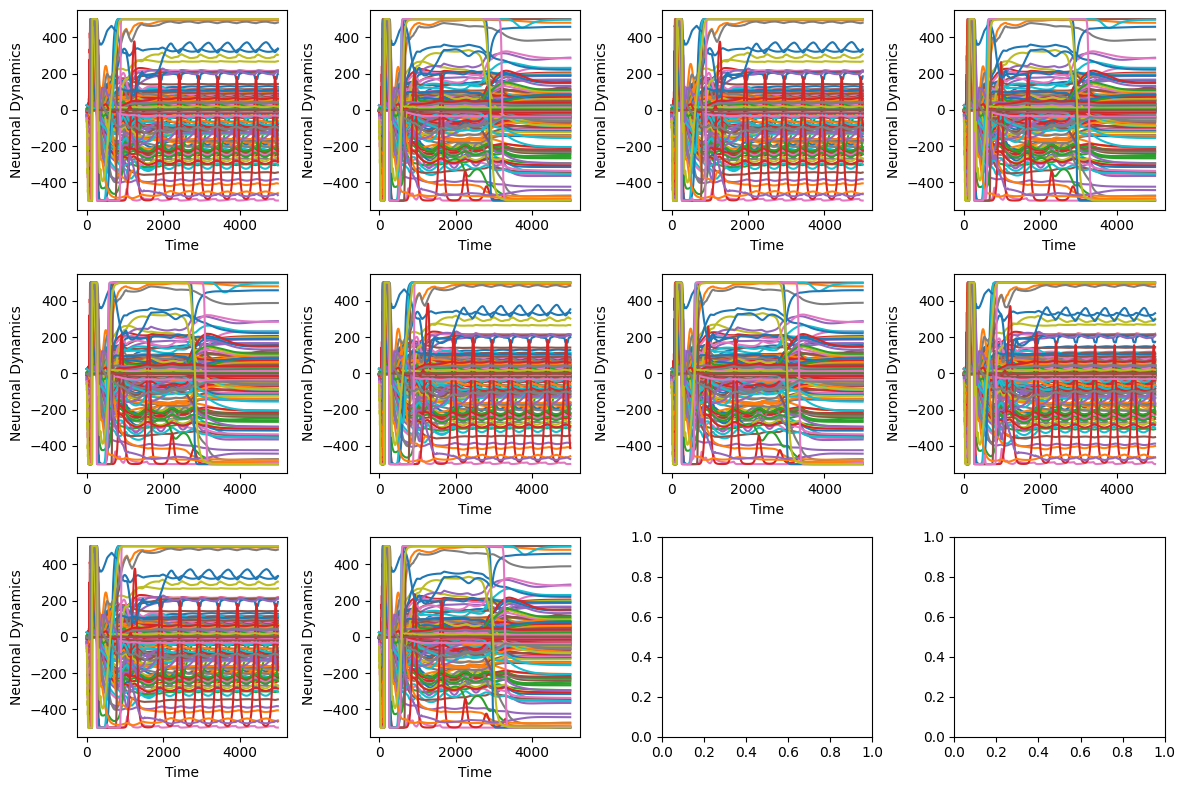

In [15]:
# Folder path containing the .npy files
folder_path = "/content"

# Get a list of .npy files in the folder
npy_files = [file for file in os.listdir(folder_path) if file.endswith(".npy")]

# Calculate the number of rows and columns for the subplots
num_files = len(npy_files)
num_rows = int(np.sqrt(num_files))
num_cols = int(np.ceil(num_files / num_rows))

# Create the subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 8))

for i, file in enumerate(npy_files):
    # Load the .npy file
    file_path = os.path.join(folder_path, file)
    data = np.load(file_path)

    data = data[:5000]

    ax = axes[i // num_cols, i % num_cols]
    ax.plot(data)

    # ax.set_title(file)
    ax.set_xlabel('Time')
    ax.set_ylabel('Neuronal Dynamics')

plt.tight_layout()
plt.show()


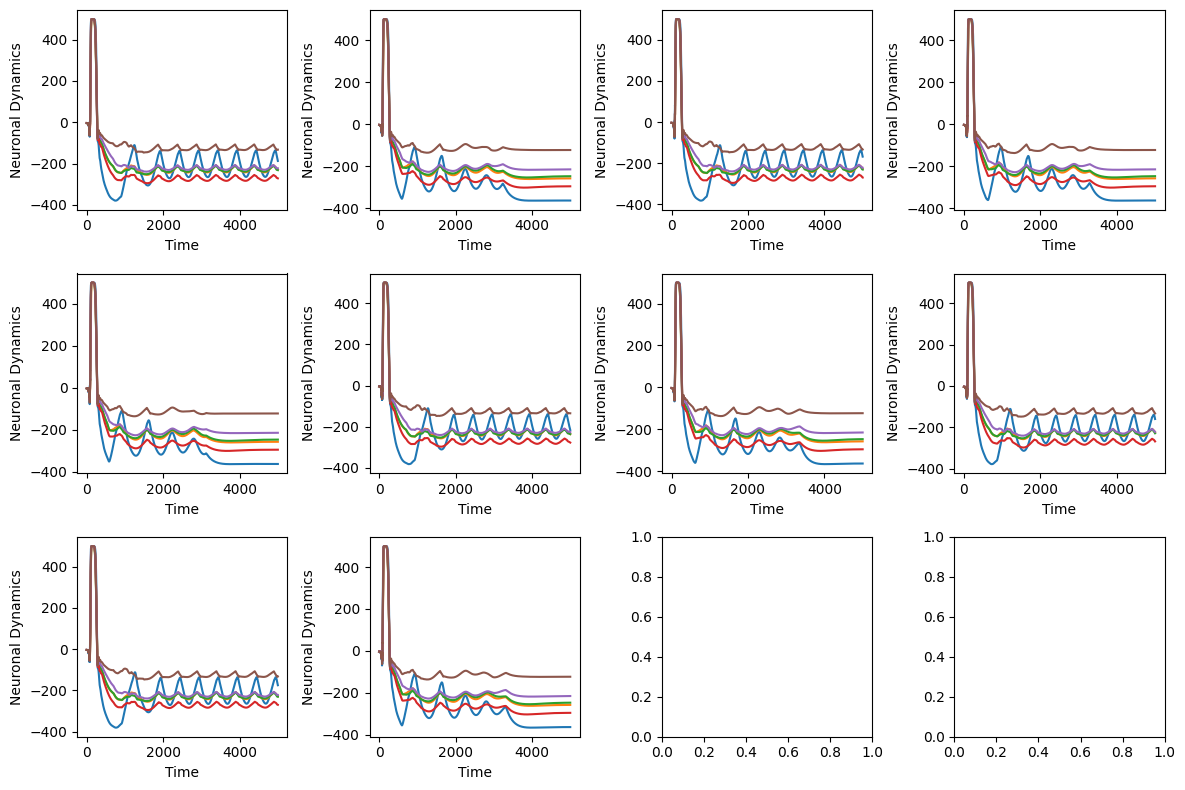

In [16]:

folder_path = "/content"
npy_files = [file for file in os.listdir(folder_path) if file.endswith(".npy")]

num_files = len(npy_files)
num_rows = int(np.sqrt(num_files))
num_cols = int(np.ceil(num_files / num_rows))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 8))

for i, file in enumerate(npy_files):
    file_path = os.path.join(folder_path, file)
    data = np.load(file_path)
    data = data[:5000]
    neurons = pd.DataFrame(data)
    neurons.index = pd.Index(range(0, neurons.shape[0], 1), name='time')

    with open('/content/drive/MyDrive/connectome/neuron_names.txt') as f:
        ncolumns = f.readlines()

    rep = [x.replace(",\n", "") for x in ncolumns]
    new = [x.replace("u", "") for x in rep]
    nlc = [x.replace("'", "") for x in new]
    nlc1 = [x.replace(" ", "") for x in nlc]
    nlc2 = [x.replace("[", "") for x in nlc1]
    nlc3 = [x.replace("]", "") for x in nlc2]
    nlc4 = [x.replace("\n", "") for x in nlc3]

    neurons.columns = nlc4

    ax = axes[i // num_cols, i % num_cols]

    # Plot a specific column, change 'column_name' to the desired column name
    ax.plot(neurons[['DB01', 'DB02', 'DB03', 'DB04', 'DB05', 'DB06']])

    ax.set_xlabel('Time')
    ax.set_ylabel('Neuronal Dynamics')

plt.tight_layout()
plt.show()


In [17]:

def plot_dynamics(neuron_names, folder_path = "/content"):
  fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 8))

  for i, file in enumerate(npy_files):
      file_path = os.path.join(folder_path, file)
      data = np.load(file_path)
      data = data[:5000]
      neurons = pd.DataFrame(data)
      neurons.index = pd.Index(range(0, neurons.shape[0], 1), name='time')

      with open('/content/drive/MyDrive/connectome/neuron_names.txt') as f:
          ncolumns = f.readlines()

      rep = [x.replace(",\n", "") for x in ncolumns]
      new = [x.replace("u", "") for x in rep]
      nlc = [x.replace("'", "") for x in new]
      nlc1 = [x.replace(" ", "") for x in nlc]
      nlc2 = [x.replace("[", "") for x in nlc1]
      nlc3 = [x.replace("]", "") for x in nlc2]
      nlc4 = [x.replace("\n", "") for x in nlc3]

      neurons.columns = nlc4

      ax = axes[i // num_cols, i % num_cols]

      # Plot a specific column, change 'column_name' to the desired column name
      ax.plot(neuron_names)
      
      ax.set_xlabel('Time')
      ax.set_ylabel('Neuronal Dynamics')

  plt.tight_layout()
  plt.show()


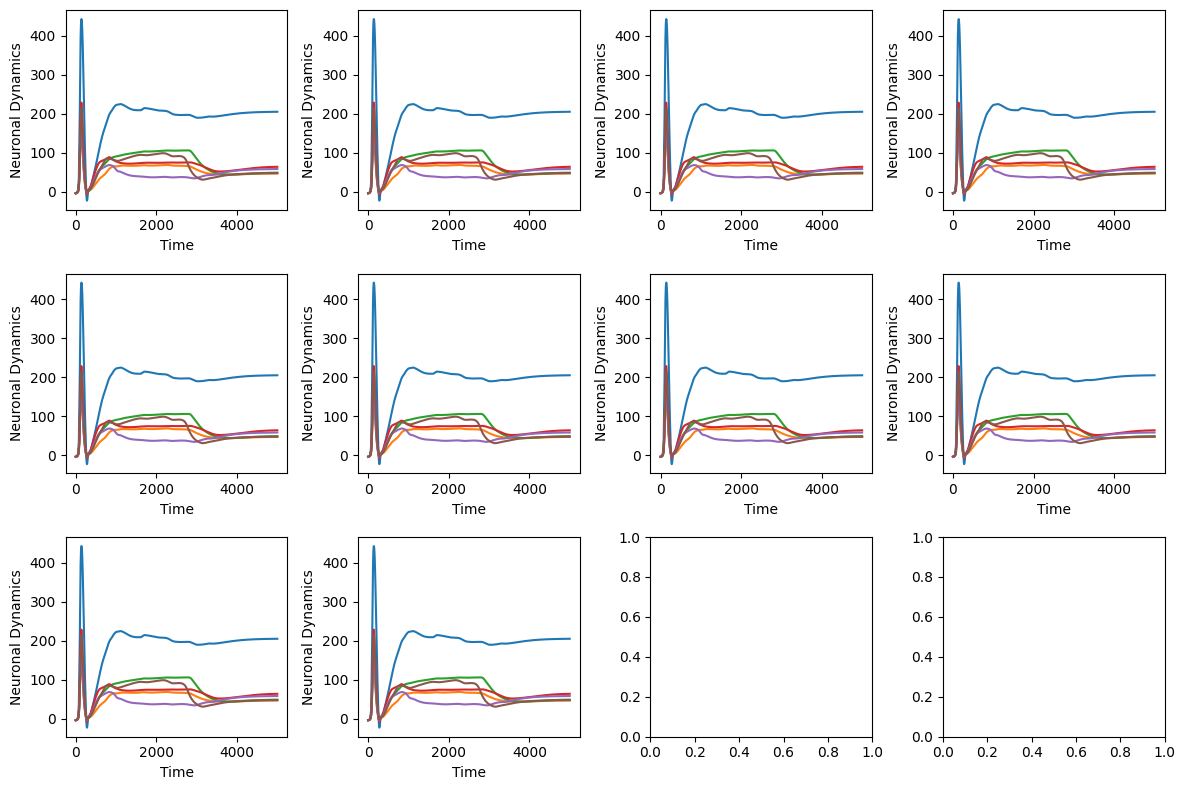

In [18]:
neuron_names = neurons[['DD01', 'DD02', 'DD03', 'DD04', 'DD05', 'DD06']]
plot_dynamics(neuron_names, folder_path = "/content")

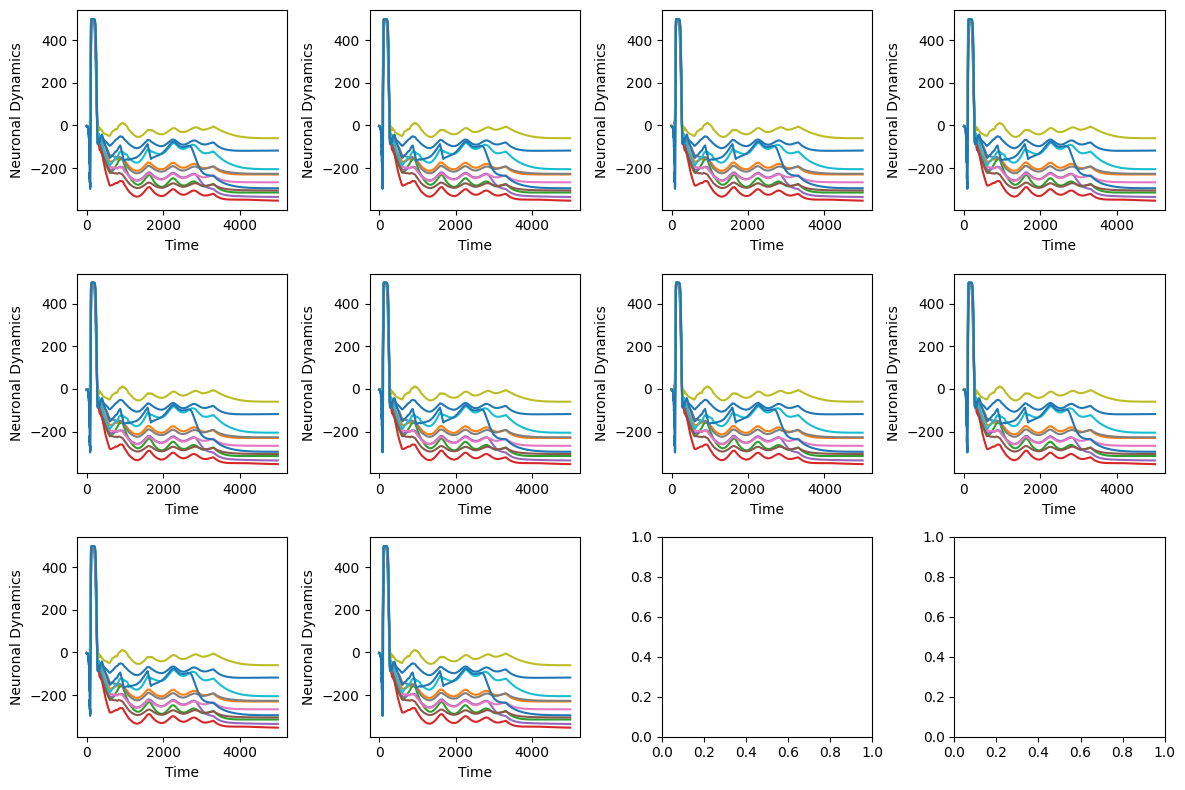

In [19]:
neuron_names = neurons[['VB01', 'VB02', 'VB03', 'VB04', 'VB05', 'VB06', 'VB07', 'VB08', 'VB09', 'VB10', 'VB11']]
plot_dynamics(neuron_names, folder_path = "/content")

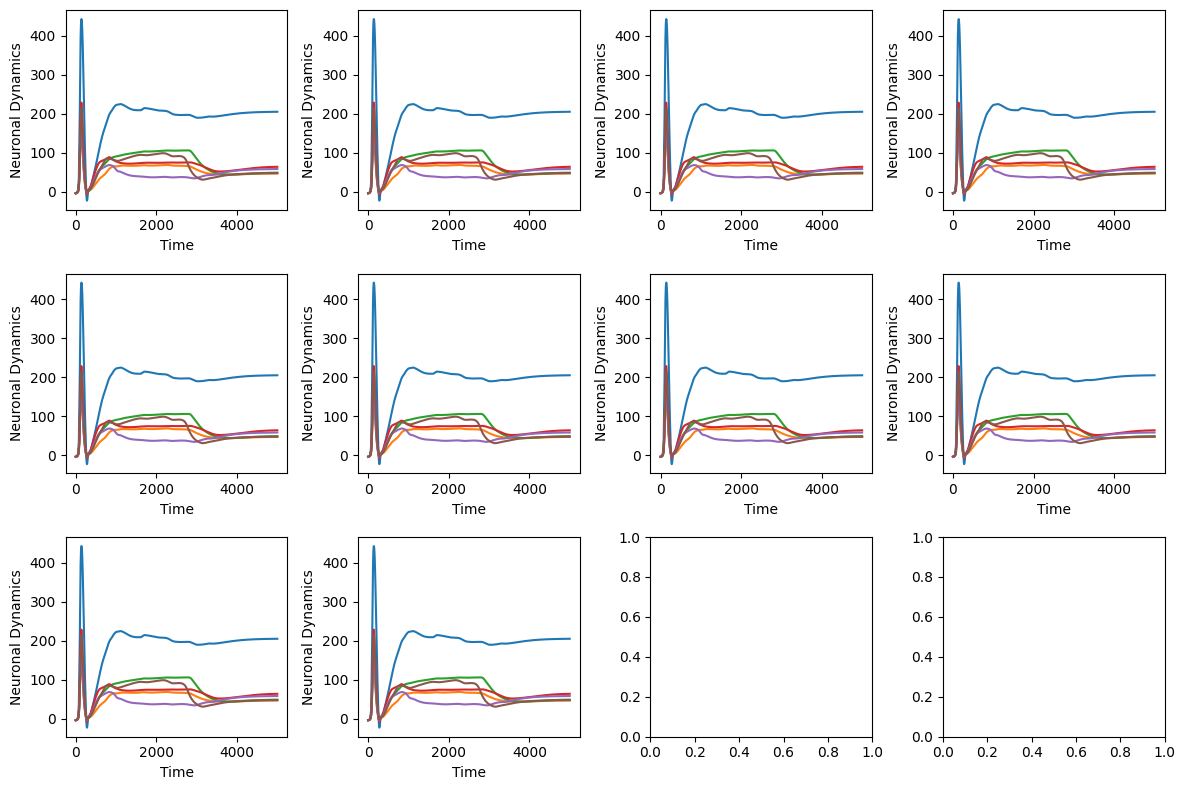

In [20]:
neuron_names = neurons[['DD01', 'DD02', 'DD03', 'DD04', 'DD05', 'DD06']]
plot_dynamics(neuron_names, folder_path = "/content")

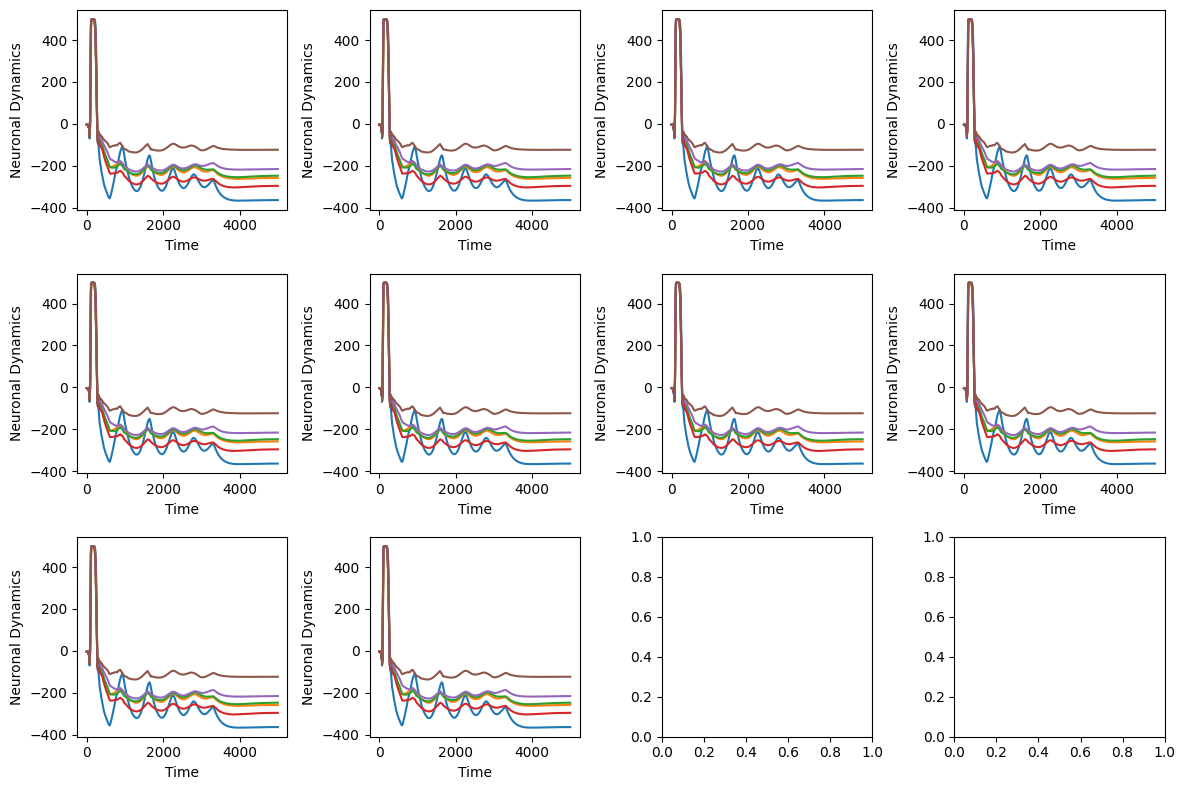

In [21]:
neuron_names = neurons[['DB01', 'DB02', 'DB03', 'DB04', 'DB05', 'DB06']]
plot_dynamics(neuron_names, folder_path = "/content")